## Importazione 

In [2]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==0.3.0 --user 
!pip install -U --pre segmentation-models --user
#!pip install git+https://github.com/qubvel/segmentation_models --user

     |████████████████████████████████| 81kB 4.6MB/s 
     |████████████████████████████████| 21.6MB 1.5MB/s 
     |████████████████████████████████| 634kB 38.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.3.0-cp36-none-any.whl size=46998 sha256=b11cf87ecdc27655ba33a65e3afc6596821f5fb63fe8d937a742a829c8b3f3c0
  Stored in directory: /root/.cache/pip/wheels/f0/20/08/c30ec4f36c3abe52bfb5a980434d4017776f17266071425c9b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=2816a1ad77ea2577bfc6a0c977741cc74d9c71f148e220632f48e7be7516a70e
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug


In [1]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/surface_normal_estimation_us/'

# Load X/Y test e codebook

In [0]:
x_test = np.load(PATH_BASE + "x_padding_test.npy")
y_test = np.load(PATH_BASE + "y_padding_test.npy")
normali_test = np.load(PATH_BASE + "normali_test.npy")

In [0]:
codebook = np.load(PATH_BASE + "codebook_labels_3d_components.npy")

# Ricostruzione modello

In [5]:
# define network parameters
BACKBONE = 'efficientnetb3'
n_classes = 41
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 2s 0us/step


In [0]:
class_weights = np.load(PATH_BASE + "label_weights_zeropadding.npy")

In [0]:
# define optomizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Calcolo output predizionale della rete

In [11]:
from keras.models import load_model
model.load_weights("best_model.h5")

OSError: ignored

In [0]:
y_test_p = model.predict(x_test, batch_size=1)

In [0]:
np.save(PATH_BASE + "prediction_test_padded.npy", y_test_p)

# Rifiltraggio output togliendo cluster numero 40

Il cluster numero 40 aggiunto per gestire il padding, deve essere rimosso. In particolare, l'immagine viene riportata alle dimensioni originali sulle quali è stato effettuato il clustering. Se un punto interno all'immagine originale presenta come classe individuata il cluster 40, si opera con nearest neighbour per riportarsi nello spazio del cluster originale.

In [0]:
def normalize(outputs):
  outputs_n = outputs / sum(outputs)
  return outputs_n

In [0]:
def unpadding(out_padded):
  out_unpadded = np.zeros((195, 260, 40))
  for h in range(0,out_unpadded.shape[0]):
    for w in range(0,out_unpadded.shape[1]):
      for c in range(0,out_unpadded.shape[2]):
        out_unpadded[h][w][c] = sample_p[h][w][c]
  return out_unpadded

# Ricalcolo superfici normali da classificazione

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

# Triangolazione di delaunay a partire dai 40 centroidi di riferimento.
def get_delaunay_triangulation(codebook):
  tri = sp.spatial.Delaunay(codebook[:,0:2]) # perform triangulation over x and y coordinates (z is function of (x,y))
  #print(tri.simplices)
  plt.figure()
  plt.axes().set_aspect('equal')
  #plt.triplot(codebook[:,0], codebook[:,1], tri.simplices.copy())
  plt.plot(codebook[:,0], codebook[:,1], 'o')
  plt.show()
  return tri.simplices

In [0]:
# Metodo che permette di ottenere la normale 3d per ogni pixel a partire dalla predizione della rete.
# INPUT
# netPrediction: shape = (H, W, 40). Predizione della rete di un'immagine. 
#                Per ogni pixel la rete fornisce un vettore di 40 probabilità (1 per ogni centroide).
# codebook:      shape = (40,3). Lista delle 40 normali di riferimento (centroidi). codebook.shape = (40,3)
# triangoli:     shape = (N, 3). Triangolazione di delaunay; ogni elemento di questo vettore è una tripla di indici di centroidi, da utilizzare
#                nel codebook ottenuto con la clusterizzazione. (es. N = 67)
# OUTPUT
# norm:          shape = (H, W, 3). Normali 3d pixel per pixel dell'immagine.

def decode(netPrediction, codebook, triangoli):
  h, w = netPrediction.shape[0:2]
  
  # for each triangle, get total prob
  tri_prob = np.dstack([np.sum(netPrediction[:,:,t], axis = -1) for t in triangoli]) 

  # get best tri
  best_tri = np.argmax(tri_prob, axis = -1)
  
  # get coefficients to most probable tri
  alphas = np.reshape([netPrediction[row, col, triangoli[best_tri[row, col]]] for row in range(h) for col in range(w)], (h, w, 3))

  # sum -> 1
  alphas = np.divide(alphas, np.reshape(np.tile(np.sum(alphas, axis = -1), (1,3)), (h, w, 3)))
  alphas = np.reshape(np.tile(alphas, (1,1,3)), (h, w,3,3))  
  alphas = np.swapaxes(alphas, 2,3)

  norm = np.multiply(alphas, codebook[triangoli[best_tri]])
  norm = np.sum(norm, axis = -2)
  
  return norm

In [0]:
y_test_p = []
for n in x_test.shape[0]:
  y_test_p_n = model.predict(x_test[n, ])
  y_test_p_n = unpadding(y_test_p_n)
  y_test_p_n = normalize(y_test_p_n)
  netPrediction_3d = decode(y_test_p_n, codebook, get_delaunay_triangulation(codebook))
  y_test_p.append(y_test_p_n)

In [0]:
np.save(PATH_BASE + "prediction_test_decoded.npy", np.asarray(y_test_p))

# Visualizzazione

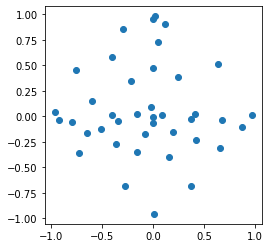

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(195, 260, 3)


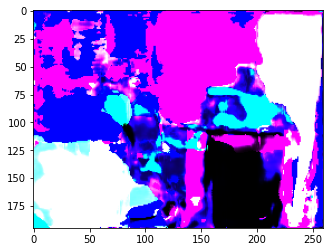

In [0]:
# chiamo la funzione di decodifica e ottengo la mappa delle normali 3d
netPrediction_3d = decode(sample_p_depadded, codebook, get_delaunay_triangulation(codebook))
print(netPrediction_3d.shape)

%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(255/2 * netPrediction_3d)

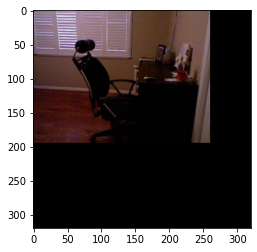

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(x_test[0])

# Valutazione

## Eval cosine

In [0]:
# pixel wise evaluation
# INPUT
# prediction:   shape = (1,3) normale predetta dalla rete (ottenuta come codifica dalle label)
# ground_truth: shape = (1,3) normale effettiva
# OUTPUT
# l'errore in radianti tra la normale passata e quella effettiva
def eval_cosine(prediction, ground_truth):
  if np.sum(ground_truth) == 0 or np.sum(prediction) == 0:
    return 0
  cosine = np.dot(prediction, ground_truth) / (np.linalg.norm(prediction) * np.linalg.norm(ground_truth))
  if (cosine <= 1 and cosine >= -1):
    return np.arccos(cosine) 
  return np.deg2rad(180) if cosine < -1 else 0

# questa funzione va chiamata su tutti i pixel di tutte le immagini del test-set o validation set.

## Soglia errori angolari rispetto a soglie

In [0]:
# TODO: effettuare la predizione su tutto il test-set (es: 30% del dataset "normals_orig.npy") con la rete. 
# Dopodichè decodificare le predizioni per ogni immagine (label -> normali 3d) e possibilmente salvare in un file (es: "prediction_test_decoded.npy").

# NOTA: nel calcolo della metrica non vanno considerati i pixel rumorosi, che sono identificati dalla tripla [0,0,0].
tot_noised_pixel = np.where(np.sum(normali_test, axis = -1) == 0)[0].shape[0]
tot_pixel = normali_test.shape[0] * normali_test.shape[1] * normali_test.shape[2]
valid_pixel = tot_pixel - tot_noised_pixel

print('Noised pixel / Tot pixel (%):', tot_noised_pixel / tot_pixel * 100)
print('Mean: ', np.rad2deg(np.sum(theta) / valid_pixel))

# es: carico da file
theta = np.load(PATH_BASE + "prediction_test_decoded.npy")

# valuto la percentuale di errori angolari inferiori rispetto ad una delle seguenti soglie
soglie_errori = [11.25, 22.5, 30]
for th in soglie_errori:
  under_th = (np.where(theta < np.deg2rad(th))[0].shape[0] - noised_pixel) / valid_pixel * 100
  print('Threshold', str(th),  under_th)